In [3]:
%%latex
import numpy as np

<IPython.core.display.Latex object>


$$
\begin{equation}
\min_{ \boldsymbol{x} }\, \frac{1}{2}\mathbf{x}^\intercal\mathbf{P}\mathbf{x} + \mathbf{q}^\intercal\mathbf{x}\\
s.t. \quad \mathbf{G}\mathbf{x} \leq \mathbf{h} \\
\text{and } \mathbf{A}\mathbf{x} = \mathbf{b} 
\end{equation}
$$

# Implementation of Support Vector Machine with CVXOPT in Python
        
## Introduction 
This notebook introduces how to train the most symple support vector machine where all training
examples are linearly separable. When the training
examples are linearly separabel, the structure of 
support vector machie is very symple. Though we
need to solve a quadratic optimization probelm, 
fortunately there are many efficient python APIs 
that can solve these optimizaiton problem quickly. 
    
Among them, [*CVXOPT*](http://cvxopt.org) is one of the most popular API that if often used in machine learning. CVXOPT can sove QP problems with equality and inequality conditions. 
            
        
In this notebook we use an artificially generated
            data in tow-dimentional spae. We generate two groups
            of data that correspond to *Class +1* and 
            *Class -1*. 
To generate the data we use `numpy.random.multivariate_normal()` 
            function to generate two-dimentional gaussiand
            distribution. They both have mean and covariance
            matrix. Mean is an analogous to the mean of 
            one-dimentional gaussian distribution. In this 
            script we set the covariance matirx as a diagonal
            matrix. 
            
The following is the standard form of QP problem that CVXOPT can handle:

$$\min_{ \boldsymbol{x} }\, \frac{1}{2}\mathbf{x}^\intercal\mathbf{P}\mathbf{x} + \mathbf{q}^\intercal\mathbf{x}$$
$$s.t. \quad \mathbf{G}\mathbf{x} \leq \mathbf{h}$$
$$\text{and } \mathbf{A}\mathbf{x} = \mathbf{b}$$
               


<html>
    <body>
        <h2>Basics of Support Vector Machines</h2>
        <h3>The primal form</h3>
        <p1>Through the training, we maximize the margine between
            the two planes 
            $\mid y_i(\mathbf{w}^\intercal\mathbf{x_i}
             + b )\mid = 1$. When we apply a restriction on 
            $\mathbf{w}$ and b that the minimal funtional margine
            is 1, the distance between the support vectors and
            the hyperplane becomes:
            $$ \frac{1}{\|\mathbf{w}\|} $$
            So all we have to do is to maximize this distance 
            with respect to $\mathbf{w}$ and b. Without any
            restriction on w and b, after the optimization, the
            minimal functional margines becomes very small, so
            we apply a restriction on $\mathbf{w}$ and b that
            all functional margines must be at leas 1.That is,
            $$ y_i(\mathbf{w}^\intercal{x_i} + b ) \geq 1 
               \text{ for all } i = 0, \dotsc, n
            $$
            Under this constraint, after the optimization the
            functional margines of the support vectors becomes
            1.
            Then our primal form is:
            $$
            \begin{equation}
            \min_{\mathbf{w}} \, \frac{1}{\|\mathbf{w}\|} \\
            s.t.\quad y_i(\mathbf{w}^\intercal\mathbf{x_i}
            + b ) \geq 1 \\ \text{ for all } i = 0,\dotsc, n 
            \end{equation}
            $$ </p1>
        <h3>The dual form</h3>
        <p1>What we actually solve is the dual form of the problem.
            The dual form is,
            $$
            \max_{\mathbf{\alpha}}\, W(\alpha) = 
            \sum_{i=1}^n \alpha_i - 
            \frac{1}{2} \sum_{i,j=1}^{n} y_i y_j \alpha_i \alpha_j
            \mathbf{x_i}^\intercal\mathbf{x_j}
            $$
            From the KKT conditions, $\mathbf{w}$ is givens as:
            $$
            \mathbf{w} = \sum_{i}\,y_i \alpha_i
            $$
            and b is calculated from the constraint of the primal
            problem
            $$
            \begin{equation}
            g_i = 1 - y_i ( \mathbf{w}^\intercal\mathbf{x_i} + b )
            \leq 0 \\
            b \leq - \mathbf{w}^\intercal\mathbf{x_i} - 1
            \quad \text{ when } y_i = -1 \\
            b \geq - \mathbf{w}^\intercal\mathbf{x_i} + 1
            \quad \text{ when } y_i = +1
            \end{equation}
            $$
            where i is the indexes of the support vectors.
            It seems ,from the above inequalities, that b can
            take a range of varues between the uppor and lower
            bound. Howerver you wii see in the following python
            implementaion that the uppor bound and the lower 
            bound is exactly tha same value. Even though the 
            restriction of the primal problem only states that
            all functioal margines must be at leas 1, the obtained
            value of b and $\mathbf{w}$ do not become so large, and 
            the functional margines for the support vectors 
            become 1.<br />
            So we choose any value of b obtained form the support
            vectors.
        </p1>
            
    </body>
</html>

<html>
    <body>
        <h2>Python code</h2>
        <p1>In this python inplementation, we define a class named
            <code>SVM</code> and its three methods 
            <code>calc_w_b</code>, <code>example_generator</code>
            , <code>fit</code> and <code>plot</code>. We train
            our svm with <code>fit</code> method and plot the
            result of our decidion boudary with the training
            data. The <code>example_generator</code> generates
            out training data of two-dimentional gaussian 
            distribution, and <code>calc_w_b</code> converts
            the dual solution $\alpha$ to the primal solution
            $\mathbf{w}$ and b. </p1> <br />
            
    </body>
</html>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix
from cvxopt import solvers
%matplotlib inline

In [ ]:

class SVM :
    def __init__ ( self, num_data ) :
        # The number of each data points.
        # Note that too large values may produce a linearly non-separable
        # data. Use 20 ~ 50.
        self.num_data = num_data

    def calc_w_b ( self, alphas, x, y  ) :
        # w is derived from the stationality contion of the KKT
        # conditions.
        self.w = np.sum ( alphas * y [ :, None ] * x, axis = 0 )
        # alphas that are not zeor means that their corresponding
        # examples are support vectors. The intercept b is determined
        # only by these support vectors. So we choose elements whose
        # alphas are not zero and their b is just the solution of our
        # primal problem.
        self.cond = ( alphas > 1e-4 ).reshape ( -1 )
        self.b = y [ self.cond ] - np.dot ( x [ self.cond ], self.w )
        # Note that all hte values of b are the same. This means that
        # these support vecotrs lie on the lines | wx + b | = -1 or +1.
        # So we can choose any of these values.

    def example_generator ( self ) :
        # The coordinates of the means in two-dimentional palane.
        x1_mean = np.array ( [ 1.0, 1.0 ] )
        x2_mean = np.array ( [ 3.0, 4.0 ] )
        # We set the covariance matrices as diagonal matrices. The diagonal
        # elements represents the variance of eace data.
        x1_cvmat = np.array ( [ [ 0.3, 0.0 ],
                                [ 0.0, 0.3 ] ] )
        x2_cvmat = np.array( [ [ 0.4, 0.0 ],
                               [ 0.0, 0.4 ] ] )
        x1 = np.random.multivariate_normal ( x1_mean, x1_cvmat, self.num_data )
        x2 = np.random.multivariate_normal ( x2_mean, x2_cvmat, self.num_data )
        y1 = ( +1 ) * np.ones ( self.num_data )
        y2 = ( -1 ) * np.ones ( self.num_data )
        x = np.concatenate ( ( x1, x2 ), axis = 0 )
        y = np.concatenate ( ( y1, y2 ), axis = 0 )
        return x, y


    def fit ( self, x, y ) :
        # format the mathematical form of our dual problem ot the form
        # that CVXOPT can handle.
        num_data = x.shape [ 0 ]
        dim = x.shape [ 1 ]
        P = y [ :, None ] * x
        P = matrix ( P.dot ( P.T ) )
        q = matrix ( - np.ones ( ( num_data, 1 ) ) )
        G = matrix ( - np.eye ( num_data ) )
        h = matrix ( np.zeros ( num_data ) )
        A = matrix ( y.reshape ( 1, -1 ) )
        b = matrix ( np.zeros ( 1 ) )
        solvers.options [ 'show_progress' ] = False
        sol = solvers.qp ( P, q, G, h, A, b )
        alphas = np.array ( sol [ 'x' ] )
        return alphas

    def plot ( self, x, y  ) :
        # plt.close ()
        fig1 = plt.figure ( num = 1, figsize = ( 8, 6 ), facecolor = 'w',
                           edgecolor = 'k' )
        ax = fig1.add_subplot ( 111 )
        # plot Class +1 data as a scatter.
        ax.scatter ( x [ y == 1 ][ :, 0 ],
                     x [ y == 1 ][ :, 1 ],
                     c = 'red', marker = 'o', label = 'Class +1' )
        # plot Class -1 data.
        ax.scatter ( x [ y == -1 ][ :, 0 ],
                     x [ y == -1 ][ :, 1 ],
                     c = 'blue', marker = '^', label = 'Class -1' )
        # We mark the supoort vectors with + mark
        ax.scatter ( x [ self.cond ] [ :, 0 ], x [ self.cond ][ :, 1 ],
         c = 'black', marker = '$+$', s = 140, label = 'Support Vectors' )
        plt.legend ( loc = 2 )
        # plot the hypterplane.
        slope = - self.w [ 0 ] / self.w [ 1 ]
        intercept = - self.b [ 0 ] / self.w [ 1 ]
        t = np.arange ( 0, 5 )
        ax.plot ( t, slope * t + intercept, 'k-' )
        plt.show ()
        # fig1.savefig ( 'fig1_script03.pdf' )


In [ ]:
svm = SVM ( num_data = 40 )
x, y = svm.example_generator ()
alphas = svm.fit ( x, y )
svm.calc_w_b ( alphas, x, y )

In [ ]:
print svm.b

<html>
    <body>
        <p1>We can see that the values of b are the seme as we
            expedted. 

In [ ]:
#svm.plot ( x, y )

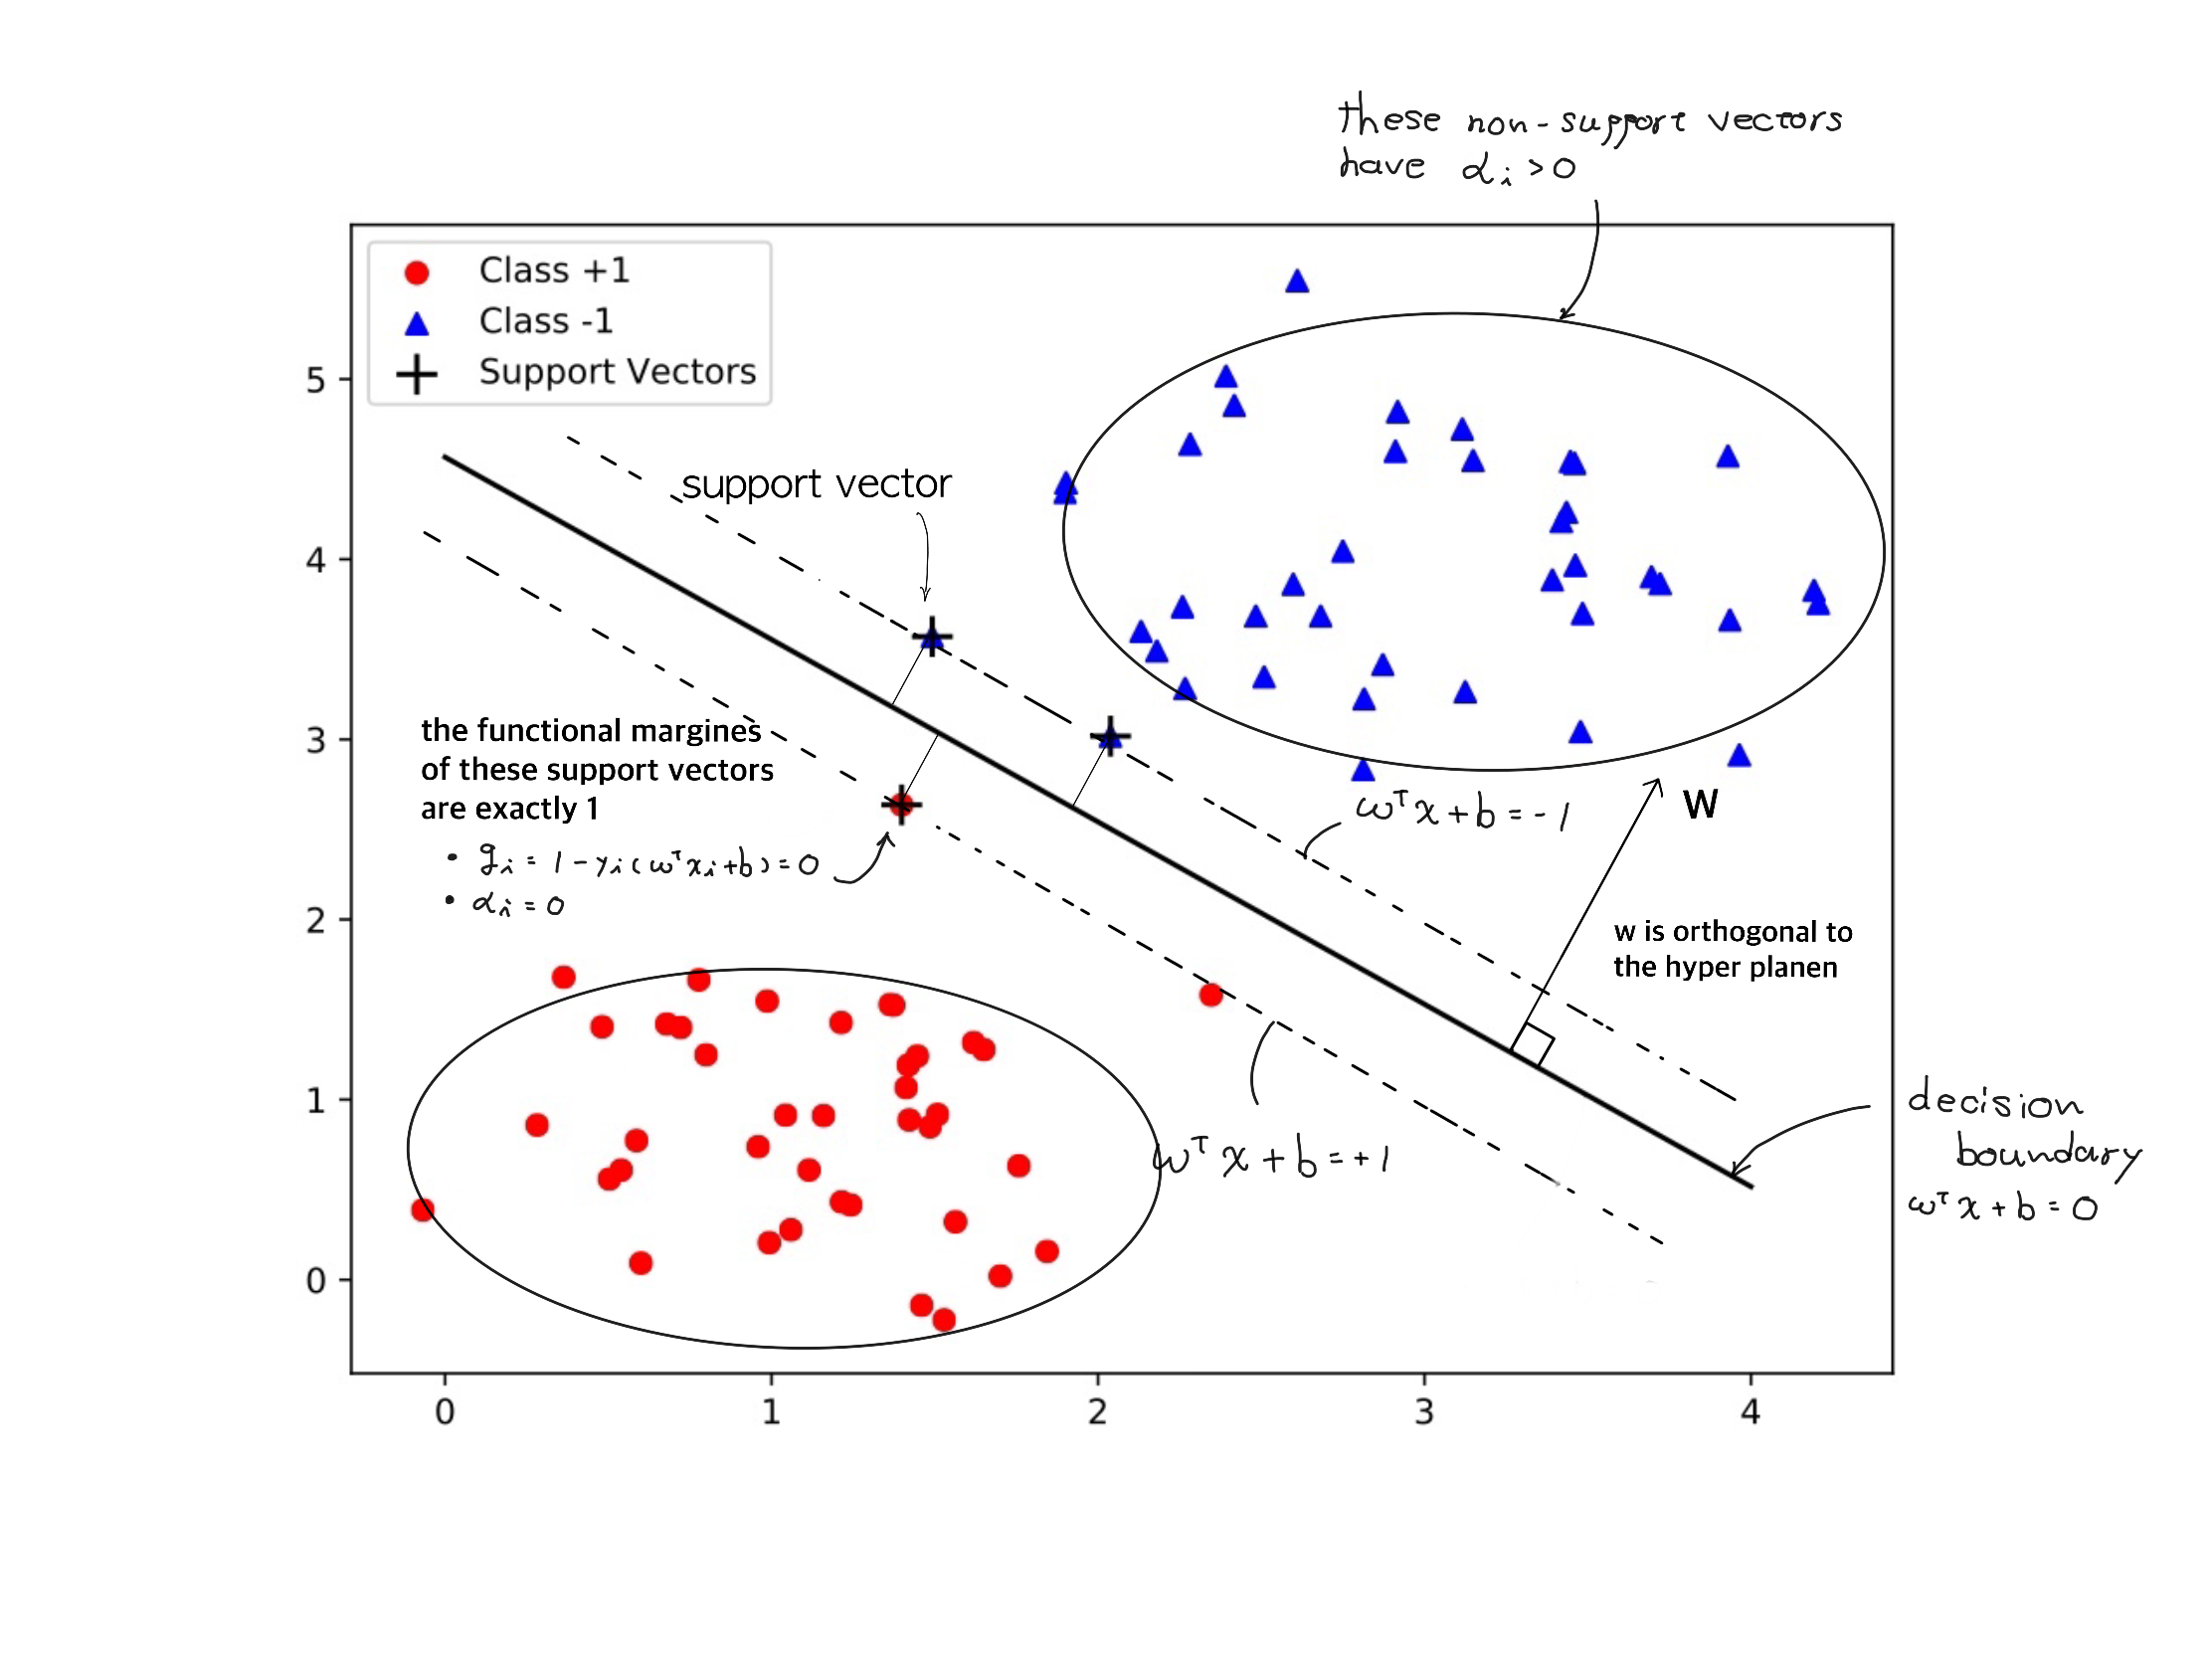